# WASP 96 b

## Learning Goals:

In this notebook, you, the user can recreate the TESS transit for the gas giant WASP 96b (see right plot in image below)! This planet was recently featured as part of the [JWST early release science](https://www.nasa.gov/image-feature/goddard/2022/nasa-s-webb-reveals-steamy-atmosphere-of-distant-planet-in-detail).

We will show you how to obtain the complementary TESS data, which may be compared against that derived using the JWST's Near-Infrared Imager and Slitless Spectrograph (NIRISS).

The notebook will teach the user how to do the following:

1. Search TESS for data on the WASP-96 system using *Lightkurve*.
2. Download a light curve.
3. Find the transiting planet via a box least squares periodogram analysis.

To learn more about the TESS mission in general and the various data products please visit the [TESS Science Support Center](https://heasarc.gsfc.nasa.gov/docs/tess/).


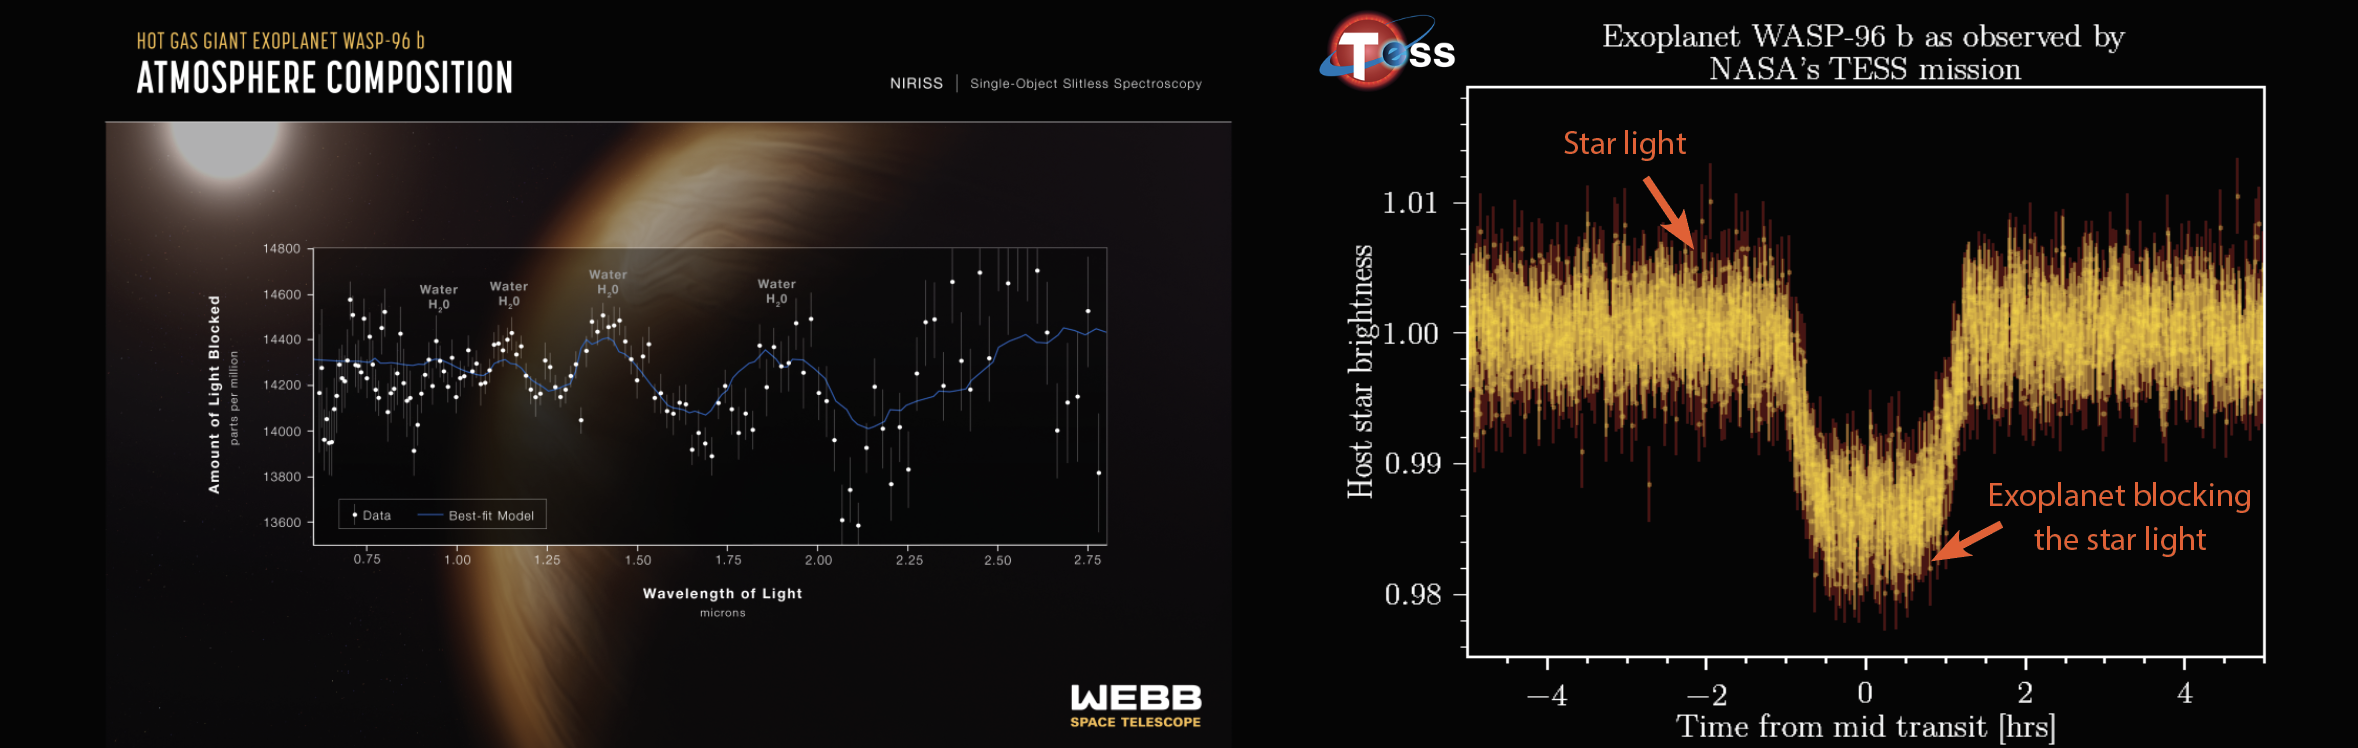

## Introduction: 
The WASP 96 system is located approximately 1,150 light-years from the Earth in the southern constellation Phoenix. The host star is a G8-type star, which is similar in mass and size to our own sun (~1.1 times). The system is known to host one planet, WASP-96 b, which is about 20 percent larger than Jupiter and has a mass roughly that of Saturn. The temperature of the planet is > 1000 degrees Fahrenheit, and it orbits its host star every 3.4 days. You can find more system parameters via the [Exoplanet Archive](https://exoplanetarchive.ipac.caltech.edu/overview/WASP-96b).

This planet is an interesting find as it is one of the few planets that have been confirmed by scientists to be sodium rich! Astronomers suspected that hot gas giants outside of our own Solar system should be rich in sodium, the seventh most common element in the universe, but due to cloudy atmospheres its detection had remained elusive.

The presence of sodium on WASP-96 b was made using the European Southern Observatory (ESO)’s Very Large Telescope as described in this fascinating [Nature Paper](https://www.nature.com/articles/s41586-018-0101-7.pdf). The form of the sodium signal also indicated that the planet has a cloudless atmosphere, and the measured abundance is similar to that found in our own solar system and to that on Earth!

Given the planets cloud-free atmosphere the object is particularly interesting for studies with the James Webb Space Telescope (JWST), and was observed on June 21st, 2022 using NIRISS! The observations obtained a [transit light curve](https://webbtelescope.org/contents/media/images/2022/032/01G72W1XZK6A79RJK2Z93D58CD) like that seen by TESS, and a [transmission spectrum](https://webbtelescope.org/contents/media/images/2022/032/01G72VSFW756JW5SXWV1HYMQK4) revealing the brightness change of individual wavelengths of infrared light between 0.6 and 2.8 microns.

The transmission spectrum revealed previously hidden details of the planet atmosphere, including the signature of water, indications of haze, and evidence of clouds that were thought not to exist based on prior observations. To learn more about this fascinating system please see the [NASA feature](https://www.nasa.gov/image-feature/goddard/2022/nasa-s-webb-reveals-steamy-atmosphere-of-distant-planet-in-detail).

Now onto how to create the TESS transiting light curve.

## Imports

This tutorial requires the [*Lightkurve package*](https://docs.lightkurve.org/index.html), which uses [Matplotlib](https://matplotlib.org/) for plotting. We will also use [Numpy](https://numpy.org/).

In [34]:
%matplotlib inline 
import lightkurve as lk 
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np

## First time users: 

If you are not that experienced with Python, or cannot download *Lightkurve*, you can run this notebook as a [Google Colab notebook](https://colab.research.google.com/?utm_source=scs-index). Colaboratory allows users to write and execute Python in your browser with zero configuration required.

All you need is a Google account and to copy and paste in the following command at the top of your colab notebook:

`!pip install lightkurve --quiet`

This downloads the Lightkurve package.

## 1. Search TESS for data on the WASP-96 system using *Lightkurve*.

Lightkurve offers a user-friendly way to analyze time series data obtained by the TESS mission. You can search for the various WASP-96 data products using the following fuctions:

- To the system in a full frame image: [`search_tesscut()`](https://docs.lightkurve.org/reference/api/lightkurve.search_tesscut.html?highlight=search_tesscut)
- To look for target pixel files: [`search_targetpixelfile()`](https://docs.lightkurve.org/reference/api/lightkurve.search_targetpixelfile.html?highlight=search_targetpixelfile)
- To obtain light curve files for WASP-96: [`search_lightcurve()`](https://docs.lightkurve.org/reference/api/lightkurve.search_lightcurve.html?highlight=search_lightcurve)


### 1.1 Accessing the data products
Let’s go through each one of the above functions and see what data is available.

In [35]:
search_ffi = lk.search_tesscut('WASP96')
search_tpf = lk.search_targetpixelfile('WASP96')
search_lcf = lk.search_lightcurve('WASP96')

In [36]:
search_ffi

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 02,2018,TESScut,1426,WASP96,0.0
1,TESS Sector 29,2020,TESScut,475,WASP96,0.0


The above table provides several important pieces of information: 

- The sector in which the object was observed. 
- The year in which the object was observed. 
- The author of the data. This can have multiple options and each is a hyperlink that when clicked will provide you with more information. 
- The cadence of the observation. 
- The name of the target. 
- The distance of the observation from your target of interest. This is useful if you conduct a cone search around your objects co-ordinates.

The table above indicates that our object was observed in sectors 2 and 29.

Let’s see if any other data exists, i.e., was it observed as a target of interest and does it have a Target Pixel File.

In [37]:
search_tpf

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 02,2018,SPOC,120,160148385,0.0
1,TESS Sector 02,2018,TESS-SPOC,1800,160148385,0.0
2,TESS Sector 29,2020,SPOC,20,160148385,0.0
3,TESS Sector 29,2020,SPOC,120,160148385,0.0
4,TESS Sector 29,2020,TESS-SPOC,600,160148385,0.0


Our object was observed as a target of interest and has several cadences of data, and several kinds of data products i.e, SPOC or TESS-SPOC. Given that there is SPOC data this means that there should be light curve files for our object already in the archive. Let’s check those out.

In [38]:
search_lcf

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector,2018,DIAMANTE,1800,160148385,0.0
1,TESS Sector 02,2018,SPOC,120,160148385,0.0
2,TESS Sector 02,2018,TESS-SPOC,1800,160148385,0.0
3,TESS Sector 02,2018,QLP,1800,160148385,0.0
4,TESS Sector 02,2018,TASOC,120,160148385,0.0
5,TESS Sector 02,2018,GSFC-ELEANOR-LITE,1800,160148385,0.0
6,TESS Sector 02,2018,TASOC,1800,160148385,0.0
7,TESS Sector 02,2018,TASOC,1800,160148385,0.0
8,TESS Sector 29,2020,SPOC,20,160148385,0.0


Wonderful! Light curves for our object of interest have already been created. 

## 2. Download a light curve:
Now on to getting the light curve for our object of interest. From the above table, it looks like there are multiple authors for our target. For the purpose of this tutorial, let’s stick to “SPOC” data products. We can return only these results using the following commands.

In [39]:
search_lcf_refined = lk.search_lightcurve('WASP96', author="SPOC")
search_lcf_refined

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 02,2018,SPOC,120,160148385,0.0
1,TESS Sector 29,2020,SPOC,20,160148385,0.0
2,TESS Sector 29,2020,SPOC,120,160148385,0.0


There are three light curves from two sectors, 2 and 29. Sector 29 has both a 20 second and 120 second cadence light curve. For this tutorial we will use the most recent data with the 20 second cadence. 

In [40]:
lk_s29f = search_lcf_refined[0].download(quality_bitmask='hard')

We can easliy plot these data using the following code;

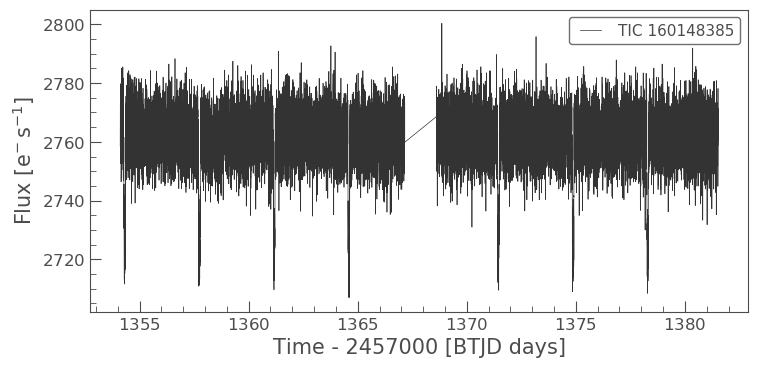

In [41]:
lk_s29f.plot()

These data show a very clear transit signal. We can use this light curve to find the exact period of the transit. 

## 3. Find the transiting planet via a box least squares periodogram analysis.

The most common method used to identify transiting exoplanets is the Box Least Squares (BLS) periodogram analysis. BLS works by modeling a transit using an upside-down top hat with four parameters: period, duration, depth, and reference time. (Please see the [Identifying transiting exoplanet signals in a light curve tutorial](https://docs.lightkurve.org/tutorials/3-science-examples/exoplanets-identifying-transiting-planet-signals.html) for more information on BLS and finding exoplanets with *Lightkurve*)

To analyze the light curve via the BLS method you must pass the data to the [`to_periodogram`](https://docs.lightkurve.org/reference/api/lightkurve.LightCurve.to_periodogram.html?highlight=to_periodogram) function and specify `bls` as the method. 

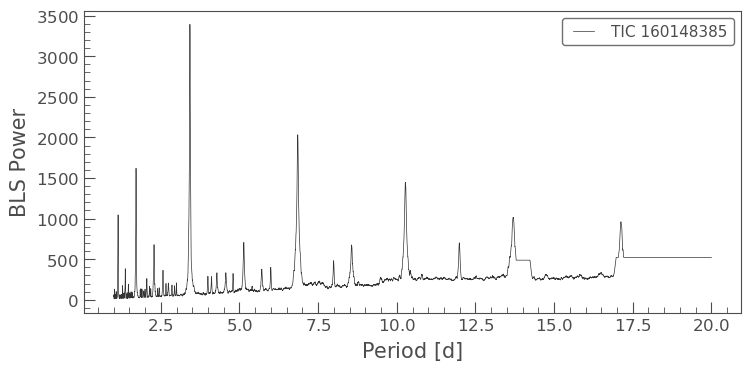

In [42]:
period = np.linspace(1, 20, 10000)
bls = lk_s29f.to_periodogram(method='bls', period=period, frequency_factor=500);
bls.plot();

The above plot indicates the power, or the likelihood of the BLS fit, for each of the periods in lightcurve data. 
There are several spikes in the plot at specific periods, but the highest power spike shows the most likely period, the remaining lower power spikes are fractional harmonics of the period.

We can pull out the most likely BLS parameters by taking their values at maximum power as shown below.

In [43]:
WASP96_b_period = bls.period_at_max_power
WASP96_b_t0 = bls.transit_time_at_max_power
WASP96_b_dur = bls.duration_at_max_power

WASP96_b_period

<Quantity 3.42464246 d>

We have now derived the period of the planet WASP96-b as ~3.4 days, which is consistant with that published.

To confirm that this period and transit time (epoch) correspond to a transit signal, we can phase-fold the light curve using these values, normalize it, and plot it.

In [44]:
lkf = lk_s29f.fold(period=WASP96_b_period, epoch_time=WASP96_b_t0).normalize()

(-5, 5)

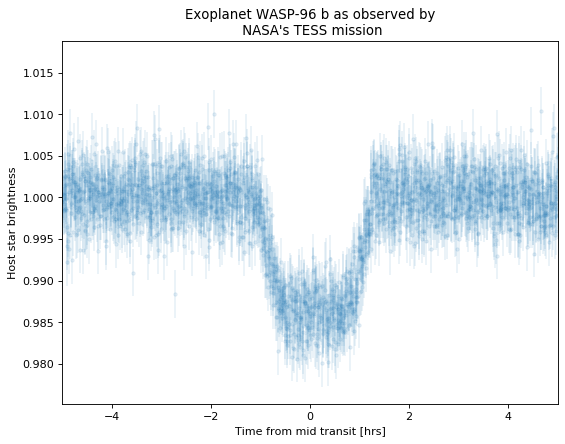

In [47]:
figure(figsize=(8, 6), dpi=80)
plt.errorbar(lkf.phase.value*24, lkf.flux.value, fmt=".", alpha=0.1, yerr=lkf.flux_err.value)
plt.title("Exoplanet WASP-96 b as observed by\n NASA's TESS mission")
plt.xlabel("Time from mid transit [hrs]")
plt.ylabel("Host star brightness")
plt.xlim(-5,5)

Wonderful. Let us now compare against the JWST image.

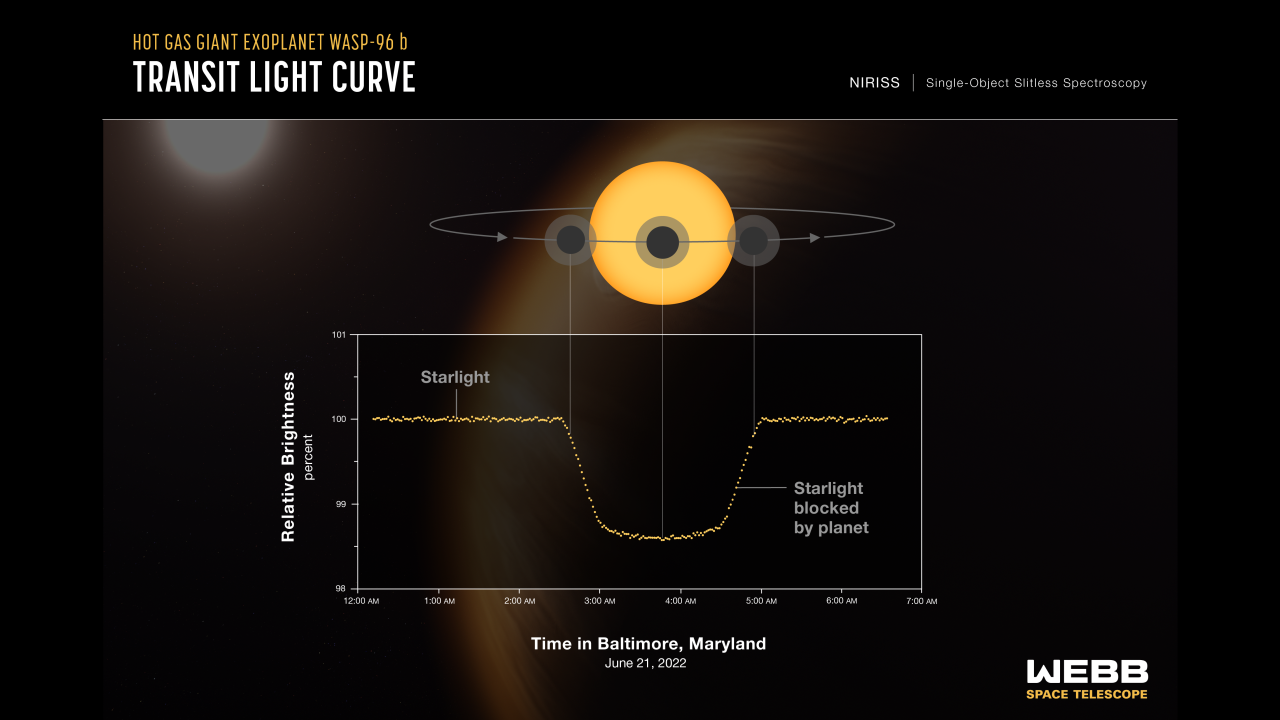